# Non-radiative carrier capture at the iodine interstitial in single cation hybrid perovskite MAPbI3

In [12]:
using CarrierCapture
using Plots, LaTeXStrings
using DataFrames
using Statistics
using CSV

In [13]:
Qmin = -35
Qmax = 50
NQ = 3000
Q = range(Qmin, stop=Qmax, length=NQ)

-35.0:0.028342780926975657:50.0

In [14]:
# from DFT data (HSE06+SoC)

E_VBM = 1.01
E_CBM = 2.50
E_BG = E_CBM - E_VBM
sx_correction = -0.057

params = Dict()

params["smoothness"] = 0.005
params["order"] = 5

# pot1 - neutral charge - from DFT data (HSE06+SoC)
nev = 200
name = "Ii0 [1]"
Q1 = [-14.76, -7.38, 0.00, 7.38, 14.76, 22.04, 29.46, 36.77, 44.16, 51.28, 58.91]
E1 = [-1079.317, -1080.135, -1080.382, -1080.256, -1080.022, -1079.969, -1080.065, -1080.200, -1079.766, -1078.179, -1074.507]
# 

pot1 = Potential(); pot1.name = name
pot1.nev = nev
pot1.Q0 = Q1[findmin(E1)[2]]; pot1.E0 = - findmin(E1)[1]
pot1.QE_data = DataFrame(Q = Q1[:], E = E1[:])
pot1.QE_data.E .+= pot1.E0
pot1.Q = Q

pot1.params = params
pot1.func_type = "spline"
fit_pot!(pot1)

# pot2 - negative charge + hole - from DFT data (HSE06+SoC)
nev = 600
name = "Ii-+h [2]"
Q2 = [0, 14.76, 22.12, 29.5, 36.78, 44.16, 51.28]
E2 = [-1077.573, -1078.451, -1078.841, -1079.306, -1079.549, -1079.0981, -1077.468]
# E negative in neut equilibrium from original calculations 

pot2 = Potential(); pot2.name = name
pot2.nev = nev
pot2.Q0 = Q2[findmin(E1)[2]]; pot2.E0 = pot1.E0
pot2.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2.QE_data.E .+= pot2.E0 + sx_correction - E_VBM
pot2.Q = Q 

params["order"] = 5
pot2.params = params
pot2.params = params
pot2.func_type = "spline"
fit_pot!(pot2)

# pot3 - neutral charge + electron + hole - from DFT data (HSE06+SoC)
nev = 150
name = "Ii0+e+h [3]"

pot3 = Potential(); pot3.name = name
pot3.nev = nev
pot3.Q0 = Q1[findmin(E1)[2]]; pot3.E0 = pot1.E0
pot3.QE_data = DataFrame(Q = Q1[:], E = E1[:])
pot3.QE_data.E .+=  pot3.E0 + E_BG
pot3.Q = Q

params["order"] = 5
pot3.params = params
pot3.func_type = "spline"
fit_pot!(pot3)

"fitting completed"

Potential fitting: Ii0 [1]
=========spline==========

Potential fitting: Ii-+h [2]
=========spline==========

Potential fitting: Ii0+e+h [3]
=========spline==========



"fitting completed"

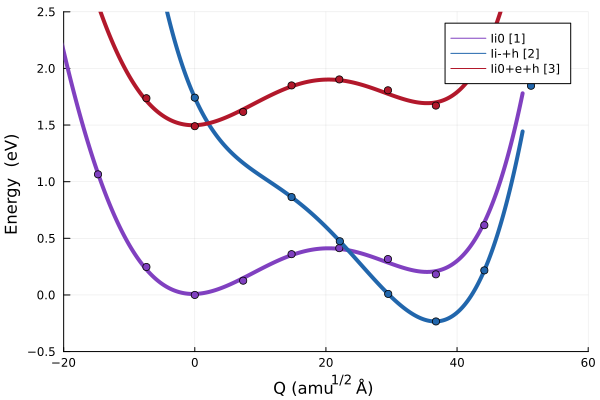

In [15]:
plt = plot()
Plotter.plot_pot!(pot1; lplt_wf = false, plt = plt, color = "#8040c0")
Plotter.plot_pot!(pot2; lplt_wf = false, plt = plt, color = "#2166ac")
Plotter.plot_pot!(pot3; lplt_wf = false, plt = plt, color = "#b2182b")
xlims!((-20, 60))
ylims!((-0.5, 2.5))

In [16]:
Qx, Ex = find_crossing(pot3, pot2)
println("Electron capture barrier: $(Ex-findmin(pot3.QE_data.E)[1]) eV")
Qx, Ex = find_crossing(pot1, pot2)
println("Hole capture barrier: $(Ex-findmin(pot2.QE_data.E)[1]) eV")
println("Hole release barrier: $(Ex-findmin(pot1.QE_data.E)[1]) eV")

Electron capture barrier: 0.025090230789114543 eV
Hole capture barrier: 0.6291928898879711 eV
Hole release barrier: 0.39519288988804746 eV


In [17]:
solve_pot!(pot1)
solve_pot!(pot2)
solve_pot!(pot3)
"Schrödinger equation solved"

"Schrödinger equation solved"

In [19]:
# we can now find the zero phonon frequency, which corresponds to the curvature of the PES at the minima.
ϵ0=pot3.ϵ[2]-pot3.ϵ[1]
ϵ0=ϵ0*1000
println("The neutral PES has a harmonic frequency of $(ϵ0) meV")

ϵ0=pot2.ϵ[2]-pot2.ϵ[1]
ϵ0=ϵ0*1000
println("The negative PES has a harmonic frequency of $(ϵ0) meV")

The neutral PES has a harmonic frequency of 5.307143428180172 meV
The negative PES has a harmonic frequency of 7.233440153618903 meV


In [20]:
## Tmin = 100
Tmax = 500
NT = 100
Volume = 4E-21  # Note that this is in units of cm^3
cut_off = 0.25
σ = 0.01
temperature = range(Tmin, stop=Tmax, length=NT)

W_electron = 0.0036 # e-ph coupling - taken from MAPI:Ii JACS 
W_hole =  0.0683 # e-ph coupling - taken from MAPI:Ii JACS 
g = 1 # degeneracy

# build a configuration coordinate for the hole capture
cc_h = conf_coord(pot2, pot1)
cc_h.W = W_hole
cc_h.g = g
calc_overlap!(cc_h; cut_off = cut_off, σ = σ, Q₀=cc_h.V1.Q0)
calc_capt_coeff!(cc_h, Volume, temperature)

# build a configuration coordinate for the electron capture
cc_e = conf_coord(pot3, pot2)
cc_e.W = W_electron
cc_e.g = g
calc_overlap!(cc_e; cut_off = cut_off, σ = σ, Q₀=cc_e.V1.Q0)
calc_capt_coeff!(cc_e, Volume, temperature)

100.0:4.040404040404041:500.0

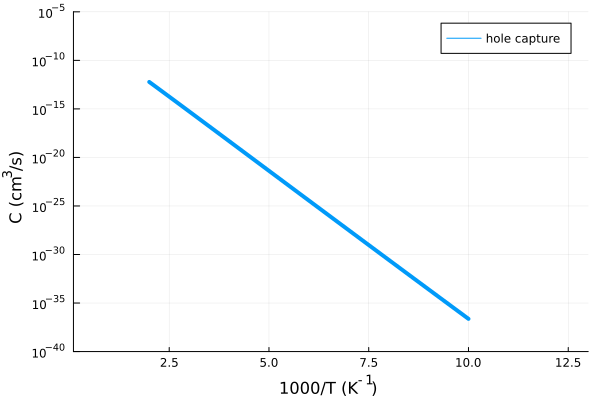

In [30]:
plt = plot()
Plotter.plot_cc!(cc_h; plt=plt, label="hole capture")
xlims!(0.1, 13)
ylims!(1E-40, 1E-5)

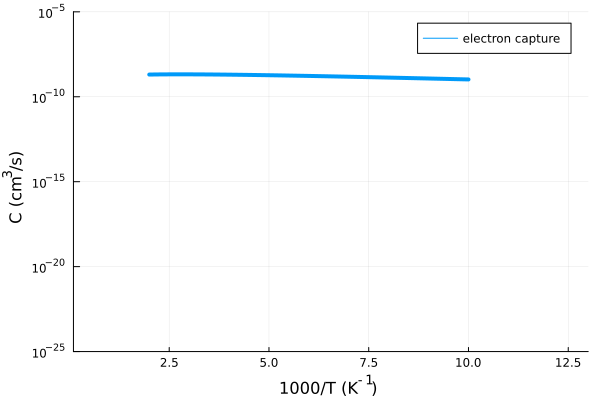

In [10]:
plt = plot()
Plotter.plot_cc!(cc_e; plt=plt, label="electron capture")
xlims!(0.1, 13)
ylims!(1E-25, 1E-5)